<a href="https://colab.research.google.com/github/akitim/comptech-winter-school-2022_covid19-prediction/blob/main/holtmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install httpx

     |████████████████████████████████| 84 kB 2.2 MB/s 
     |████████████████████████████████| 68 kB 6.5 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 


In [4]:
import pandas as pd
import itertools
from scipy.signal import savgol_filter
from tqdm.notebook import tqdm
import json
from collections import defaultdict
import pickle
from matplotlib import pyplot as plt
import pickle
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
from datetime import date, timedelta
import pickle
import httpx
import json
import warnings
warnings.filterwarnings('ignore')

In [5]:
path = "https://storage.yandexcloud.net/covid-19/people_structure.csv"
data = pd.read_csv(path)
# data = pd.read_csv('people_structure.csv')

In [6]:
data['date'] = pd.to_datetime(data.date)

In [7]:
df_rus = data[data['location']== 'Russia']
ts_rus = df_rus.set_index(pd.DatetimeIndex(df_rus['date'])).asfreq('d').total_cases

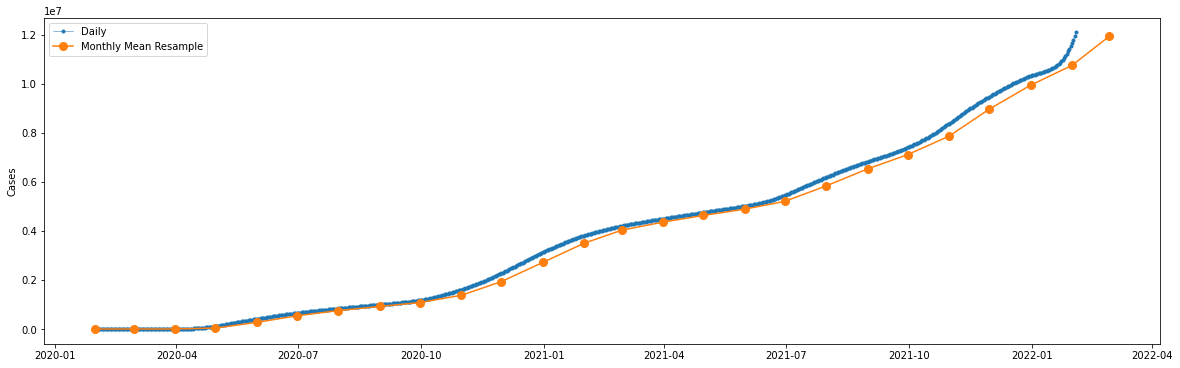

In [8]:
import warnings
import matplotlib.pyplot as plt


y = ts_rus
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Cases')
ax.legend();

In [9]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

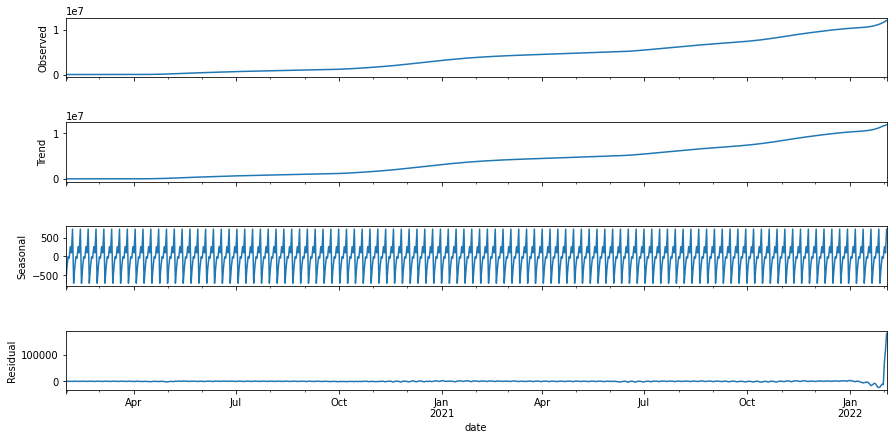

In [10]:
seasonal_decompose(y)

In [11]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

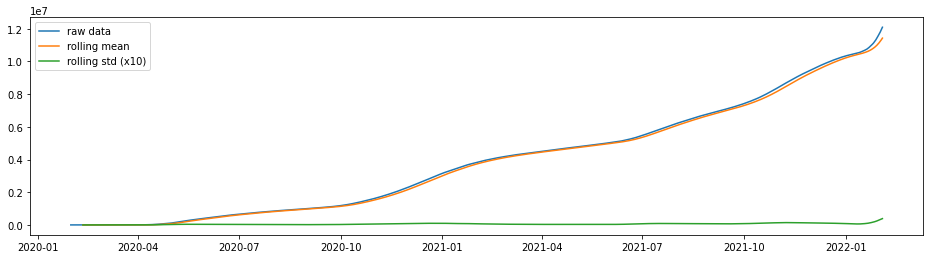

In [12]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [13]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [14]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = 3.099
P-value = 1.000
Critical values :
	1%: -3.439477677285233 - The data is not stationary with 99% confidence
	5%: -2.865568186630048 - The data is not stationary with 95% confidence
	10%: -2.5689150720653977 - The data is not stationary with 90% confidence


Make the Data Stationary
To proceed with our time series analysis, we need to stationarize the dataset. There are many approaches to stationarize data, but we’ll use de-trending, differencing, and then a combination of the two.

Detrending
This method removes the underlying trend in the time series:

 > Is the de-trended data stationary ?
Test statistic = -4.972
P-value = 0.000
Critical values :
	1%: -3.439960610754265 - The data is  stationary with 99% confidence
	5%: -2.8657809735786244 - The data is  stationary with 95% confidence
	10%: -2.5690284373908066 - The data is  stationary with 90% confidence


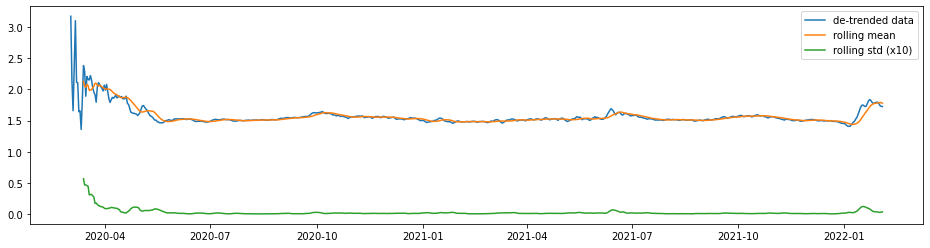

In [15]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

Differencing
This method removes the underlying seasonal or cyclical patterns in the time series. Since the sample dataset has a 12-month seasonality, I used a 12-lag difference:

 > Is the 12 lag differenced data stationary ?
Test statistic = 1.489
P-value = 0.997
Critical values :
	1%: -3.4396995339981444 - The data is not stationary with 99% confidence
	5%: -2.8656659438580796 - The data is not stationary with 95% confidence
	10%: -2.5689671530263554 - The data is not stationary with 90% confidence


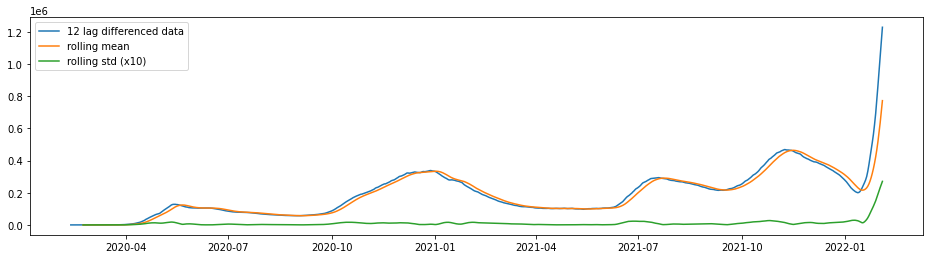

In [16]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -4.561
P-value = 0.000
Critical values :
	1%: -3.4401331487581754 - The data is  stationary with 99% confidence
	5%: -2.865856987951189 - The data is  stationary with 95% confidence
	10%: -2.569068936347423 - The data is  stationary with 90% confidence


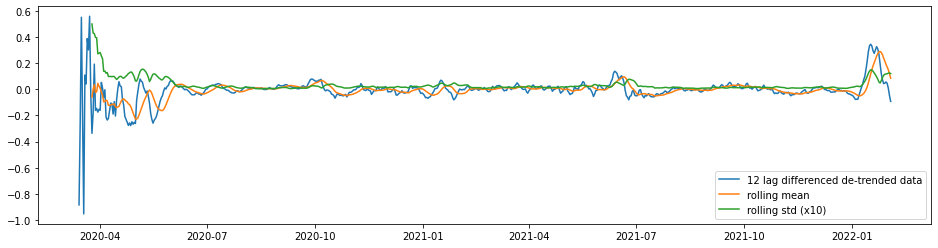

In [17]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [18]:
predict_date = 30
train, test, valid = ts_rus.iloc[:-predict_date-predict_date], ts_rus.iloc[-predict_date-predict_date:-predict_date],ts_rus.iloc[-predict_date:]
y = ts_rus.iloc[:-predict_date]

Holt’s Linear Trend Method
Suitable for time series data with a trend component but without a seasonal component 

Expanding the SES method, the Holt method helps you forecast time series data that has a trend. In addition to the level smoothing parameter α introduced with the SES method, the Holt method adds the trend smoothing parameter β*. Like with parameter α, the range of β* is also between 0 and 1.

The sample code below contains two different variants within the Holt method. Both fits have the α = 0.6, β* = 0.2 as parameter values. The fit1 is the default Holt’s additive model, and the fit2 is an exponential model. An exponential model would be appropriate for situations where the increase or decrease starts slowly but then accelerates rapidly.

In [19]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    #mse1 = ((fcast1 - y_to_test) ** 2).mean()
    mdape = np.median((np.abs(np.subtract(y_to_test, fcast1)/ y_to_test)))
    print('The Median Absolute Percentage Error of Holt''s Linear trend {}'.format(round(mdape, 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mdape2 = np.median((np.abs(np.subtract(y_to_test, fcast2)/ y_to_test)))
    print('The Median Absolute Percentage  Error of Holt''s Exponential trend {}'.format(round(mdape2, 2)))
    #mse2 = ((fcast2 - y_to_test) ** 2).mean()
    #print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

The Median Absolute Percentage Error of Holts Linear trend 0.01
The Median Absolute Percentage  Error of Holts Exponential trend 0.01


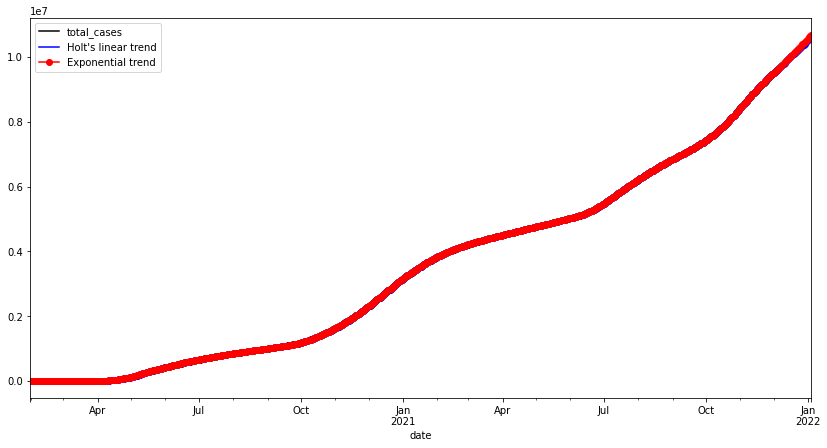

In [20]:
holt(ts_rus.iloc[:-predict_date-predict_date],train,test,0.6,0.2,predict_date)

Holt-Winters’ Seasonal Method
Suitable for time series data with trend and/or seasonal components

Suitable for time series data with trend and/or seasonal components

The Holt-Winters model extends Holt to allow the forecasting of time series data that has both trend and seasonality, and this method includes this seasonality smoothing parameter: γ.

There are two general types of seasonality: Additive and Multiplicative. 

Additive: xt = Trend + Seasonal + Random
Seasonal changes in the data stay roughly the same over time and don’t fluctuate in relation to the overall data.
Multiplicative: xt = Trend * Seasonal * Random
The seasonal variation changes in relation to the overall changes in the data. So, if the data is trending upward, the seasonal differences grow proportionally as well.
Here’s a helpful visual: [add-multi](https://www.bounteous.com/sites/default/files/additive-vs-multiplicative.png)

Once you figure out which type of seasonality you’re dealing with in your data, you can identify the frequency of seasonality or m. For data with a quarterly seasonal pattern, m = 4, while for a monthly seasonal data pattern, m = 12. Our sample data has a yearly seasonal pattern with 2 years of data, and we aggregated it by week, so each data point is one week, so m = 52.

The Python statsmodels module provides users with a range of parameter combinations based on the trend types, seasonality types, and other options for doing Box-Cox transformations. This package is kind of like the time series version of grid search for hyperparameter tuning. To find out more, see this [documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html) and this [detailed explanation](https://otexts.com/fpp2/holt-winters.html) to help you choose the one that suits your data best.

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        #mse1 = ((fcast1 - y_to_test) ** 2).mean()
        mdape = np.median((np.abs(np.subtract(y_to_test, fcast1)/ y_to_test)))
        print('The Median Absolute Percentage Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(mdape, 2)))
        #print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              #'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mdape2 = np.median((np.abs(np.subtract(y_to_test, fcast2)/ y_to_test)))
        print('The Median Absolute Percentage Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(mdape2, 2)))
        #mse2 = ((fcast2 - y_to_test) ** 2).mean()
        #print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
             # 'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mdape3 = np.median((np.abs(np.subtract(y_to_test, fcast3)/ y_to_test)))
        print('The Median Absolute Percentage Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(mdape3, 2)))
        #mse3 = ((fcast3 - y_to_test) ** 2).mean()
        #print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              #'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mdape4 = np.median((np.abs(np.subtract(y_to_test, fcast4)/ y_to_test)))
        print('The Median Absolute Percentage Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(mdape4, 2)))
        #mse4 = ((fcast3 - y_to_test) ** 2).mean()
        #print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              #'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Median Absolute Percentage Error of additive trend, multiplicative seasonal of period season_length=52 and a Box-Cox transformation nan
The Median Absolute Percentage Error of additive damped trend, multiplicative seasonal of period season_length=52 and a Box-Cox transformation 1.0


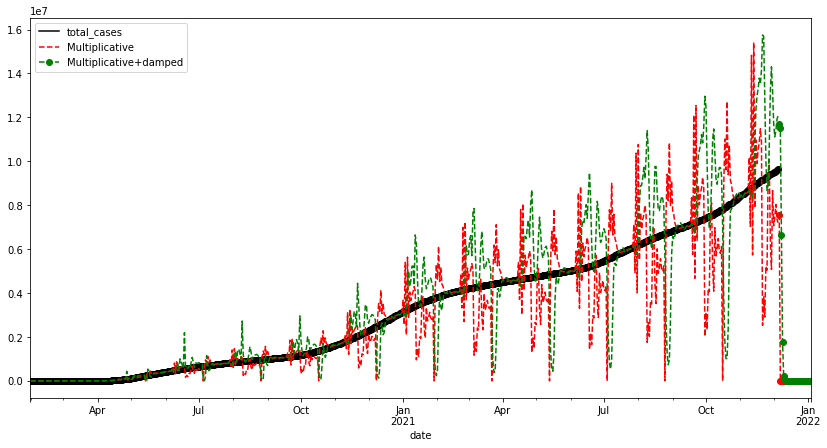

In [22]:
holt_win_sea(ts_rus.iloc[:-predict_date-predict_date], train, test,'multiplicative',52, predict_date)

The visualization of the results for the Holt-Winters method shows the additive (red line) compared to the additive + damped (green line) trends. Based on the visualization, we see that the Holt-Winters model fits the actual data best, so far. However, the RMSE is not better than the results from the simple SES model. And we can also tell that the forecast starts to drop off towards the end.

## SARIMA
Suitable for time series data with trend and/or seasonal components

While exponential smoothing models use weighted averages of past observations to forecast new values, Auto-Regressive Integrated Moving Average or ARIMA models look at autocorrelations or serial correlations in the data. In other words, ARIMA models look at differences between values in the time series.

You’ll notice that SARIMA includes several parameters that can be tuned to achieve optimal performance. 
Trend Elements:

p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.
Seasonal Elements:

P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.
In order to get the best prediction, it’s important to find the values of SARIMA(p,d,q)(P,D,Q)m that optimize a metric of interest. For the purposes of this brief blog post, we will just use a "grid search" to iteratively explore different combinations of parameters. Learn more about grid search.

The evaluation metric we’ll use for the grid search is the AIC (Akaike Information Criterion) value. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. In general, we want to pick the combination with the lowest AIC value.

In [23]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [24]:
#sarima_grid_search(y,52)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:10716.851015216042

The grid search tested all possible combinations of variables, and printed out the set that resulted in the lowest AIC, and we can see that SARIMA(1, 1, 1)x(1, 1, 0, 52) has the lowest AIC value. Since this method chose the best parameters, we will use this method to fit our model and compare the results with all the previous models discussed above.

In [25]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mdape = np.median((np.abs(np.subtract(y_to_test, y_forecasted)/ y_to_test)))
    print('The Median Absolute Percentage Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(mdape, 2)))
    #mse = ((y_forecasted - y_to_test) ** 2).mean()
    #print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mdape_dynamic = np.median((np.abs(np.subtract(y_to_test, y_forecasted_dynamic)/ y_to_test)))
    print('The Median Absolute Percentage Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(mdape_dynamic, 2)))
    #mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    #print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9930      0.006    161.949      0.000       0.981       1.005
ma.L1          0.0233      0.059      0.398      0.690      -0.091       0.138
ar.S.L52      -0.9760      0.033    -29.199      0.000      -1.041      -0.910
ma.S.L52       1.1534      0.081     14.180      0.000       0.994       1.313
sigma2      1.094e+06    1.8e+05      6.081      0.000    7.42e+05    1.45e+06


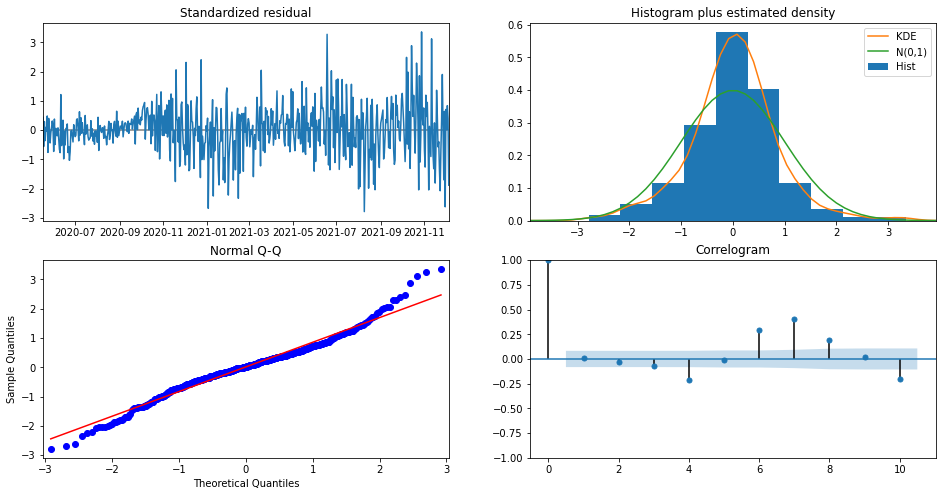

The Median Absolute Percentage Error of SARIMA with season_length=52 and dynamic = False nan


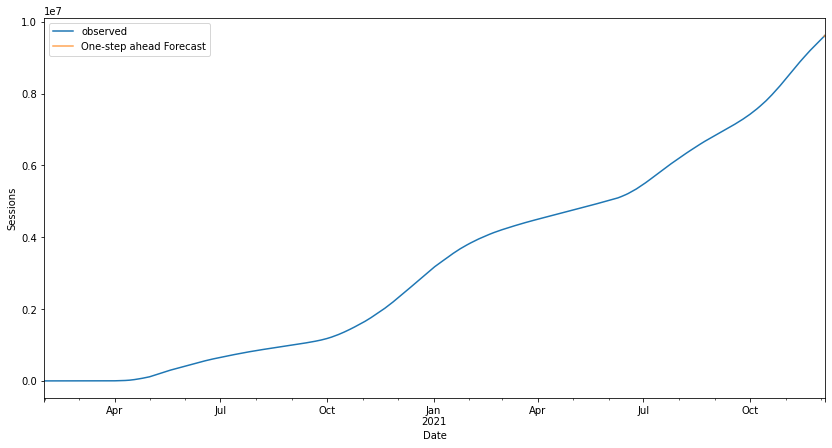

The Median Absolute Percentage Error of SARIMA with season_length=52 and dynamic = True nan


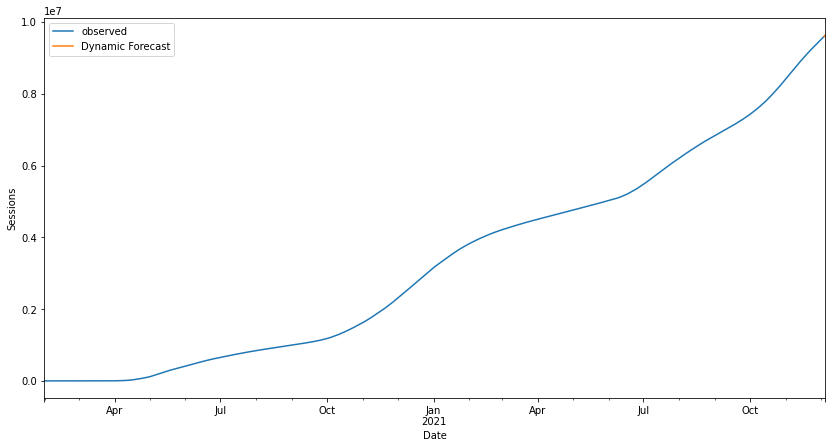

In [26]:
model = sarima_eva(ts_rus.iloc[:-predict_date-predict_date],(1, 1, 1),(1, 1, 1, 52),52,'2021-12-04',test)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9972      0.004    233.109      0.000       0.989       1.006
ma.L1         -0.0591      0.076     -0.781      0.435      -0.207       0.089
ar.S.L52      -0.2476      0.112     -2.213      0.027      -0.467      -0.028
ma.S.L52      -0.7835      0.107     -7.336      0.000      -0.993      -0.574
sigma2      1.159e+06   9.97e+04     11.622      0.000    9.64e+05    1.35e+06


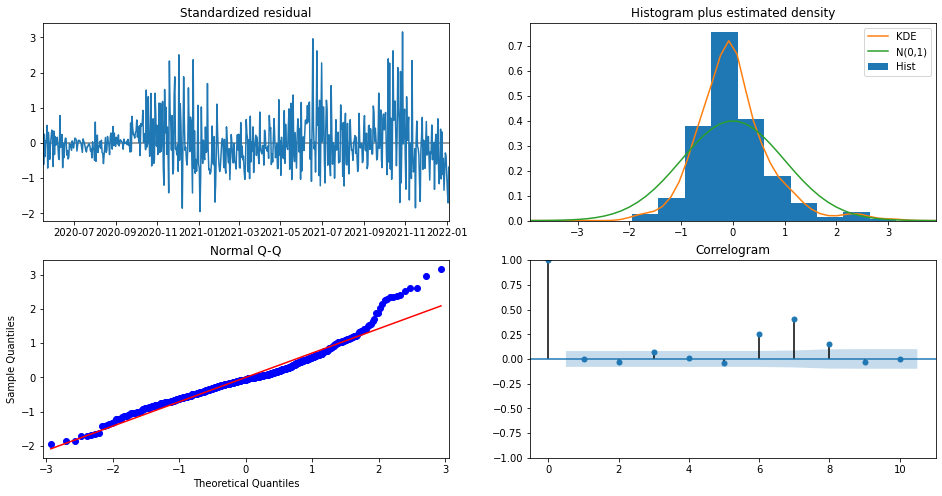

The Median Absolute Percentage Error of SARIMA with season_length=52 and dynamic = False nan


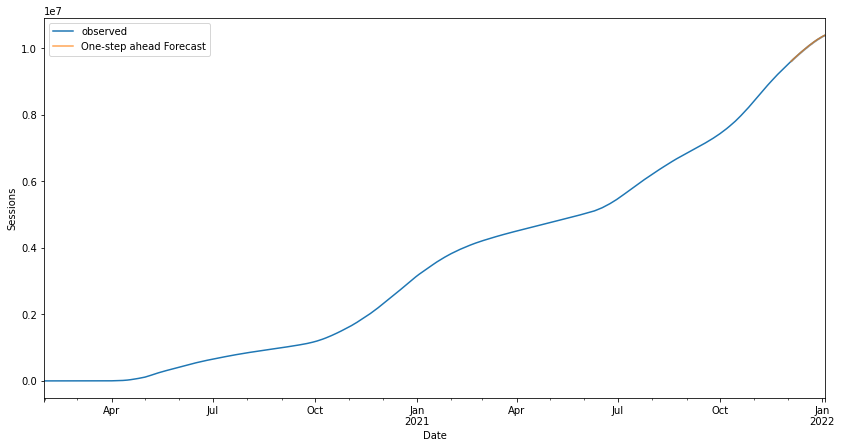

The Median Absolute Percentage Error of SARIMA with season_length=52 and dynamic = True nan


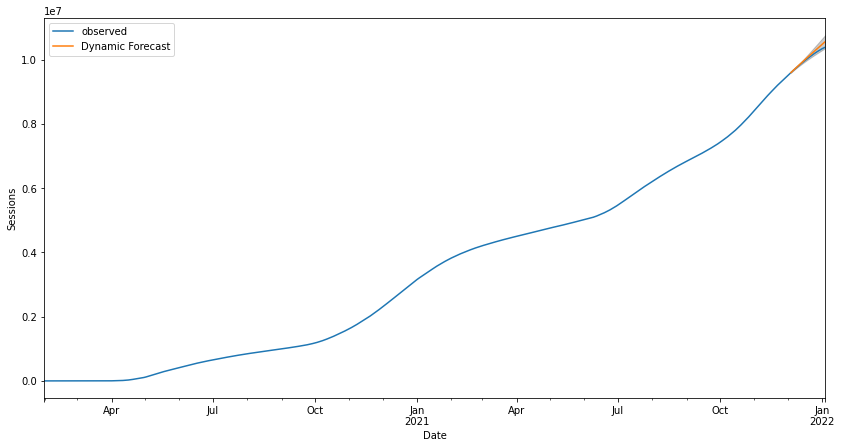

In [27]:
model = sarima_eva(ts_rus.iloc[:-predict_date],(1, 1, 1),(1, 1, 1, 52),52,'2021-12-04',valid)

## Making Predictions
Now that we have a well-fit model, let’s do some forecasting!

To get the forecast for sales in the next year, we enter steps=52. The results produce both a table showing the Predicted_Mean, Lower Bound and Upper Bound, and the prediction graphs.

In [28]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

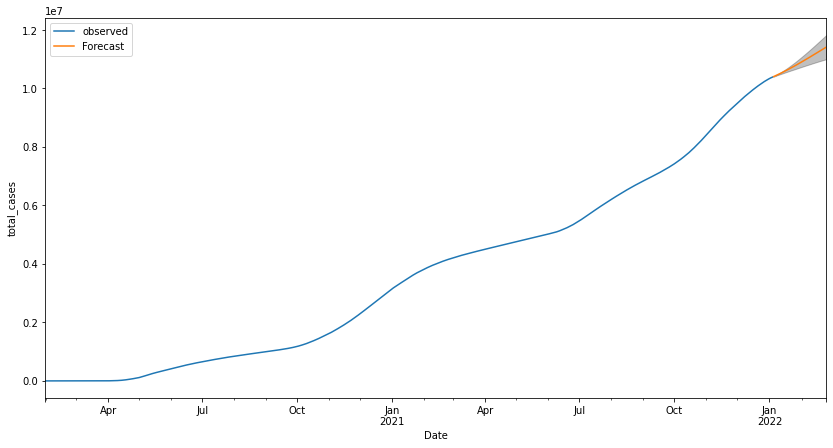

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-01-05,10406518.25264960,10404407.45378724,10408629.05151197
1,2022-01-06,10422809.35261421,10418206.10631926,10427412.59890917
2,2022-01-07,10439649.46700105,10432035.30903933,10447263.62496277
3,2022-01-08,10456358.12913162,10445289.33884960,10467426.91941364
4,2022-01-09,10473073.07789537,10458158.03487727,10487988.12091347


In [29]:
final_table = forecast(model,52,y)
final_table.head()